# LQ Approximation with `QuantEcon.jl`

In [1]:
using QuantEcon
using Plots

See the [Python version](http://nbviewer.jupyter.org/github/OyamaZemi/MirandaFackler.notebooks/blob/master/lqapprox/lqapprox_py.ipynb) for the formulation.

In [2]:
"""
Return an approximating LQ instance.

Gradient of f: Df_star = [f_s, f_x]
Hessian of f: DDf_star = [f_ss f_sx; f_sx f_xx]
Gradient of g: Dg_star = [g_s, g_x]

"""
function approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)
    n = 2  # Dim of state variable (1, s)
    k = 1  # Dim of control variable x
    sx_star = [s_star, x_star]
    
    # (1, s)' R (1, s) + 2 x N (1, s) + x Q x
    Q = Array{Float64}(k, k)
    R = Array{Float64}(n, n)
    N = Array{Float64}(k, n)
    R[1, 1] = -(f_star - Df_star' * sx_star + (sx_star' * DDf_star * sx_star) / 2)
    R[2, 2], N[1, 2], N[1, 2], Q[1, 1] = -DDf_star / 2
    R[2, 1], N[1, 1] = -(Df_star - DDf_star * sx_star) / 2
    R[1, 2] = R[2, 1]
    
    # A (1, s) + B x + C w
    A = Array{Float64}(n, n)
    B = Array{Float64}(n, k)
    C = zeros(n, 1)
    A[1, 1], A[1, 2], B[1, 1] = 1, 0, 0
    A[2, 1] = g_star - Dg_star' * sx_star
    A[2, 2], B[2, 1] = Dg_star
    
    lq = LQ(Q, R, A, B, C, N, bet=discount)
    return lq
end

approx_lq

## Optimal Economic Growth

We consider the following optimal growth model from Miranda and Fackler, Section 9.7.1:

* $f(s, x) = \dfrac{(s - x)^{1-\alpha}}{1-\alpha}$,
* $g(s, x) = \gamma + x^{\beta}$.

In [3]:
alpha = 0.2
bet = 0.5
gamm = 0.9
discount = 0.9;

Function definitions:

In [4]:
f(s, x) = (s - x)^(1 - alpha) / (1 - alpha)
f_s(s, x) = (s - x)^(-alpha)
f_x(s, x) = -f_s(s, x)
f_ss(s, x) = -alpha * (s - x)^(-alpha - 1)
f_sx(s, x) = -f_ss(s, x)
f_xx(s, x) = f_ss(s, x)

g(s, x) = gamm * x + x^bet
g_s(s, x) = 0
g_x(s, x) = gamm + bet * x^(bet - 1);

Steady state:

In [5]:
x_star = ((discount * bet) / (1 - discount * gamm))^(1 / (1 - bet))
s_star = gamm * x_star + x_star^bet
s_star, x_star

(7.416897506925212, 5.6094182825484795)

`(s_star, x_star)` satisfies the Euler equations:

In [6]:
f_x(s_star, x_star) + discount * f_s(g(s_star, x_star), x_star) * g_x(s_star, x_star)

1.1102230246251565e-16

Construct $f^*$, $\nabla f^*$, $D^2 f^*$, $g^*$, and $\nabla g^*$:

In [7]:
f_star = f(s_star, x_star)
Df_star = [f_s(s_star, x_star), f_x(s_star, x_star)]
DDf_star = [f_ss(s_star, x_star) f_sx(s_star, x_star);
            f_sx(s_star, x_star) f_xx(s_star, x_star)]
g_star = g(s_star, x_star)
Dg_star = [g_s(s_star, x_star), g_x(s_star, x_star)];

### LQ Approximation

Generate an LQ instance that approximates our dynamic optimization problem:

In [8]:
lq = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)

QuantEcon.LQ([0.0491487], [-0.240852 -0.533012; -0.533012 0.0491487], [1.0 0.0; 1.18421 0.0], [0.0; 1.11111], [0.0; 0.0], [0.533012 -0.0491487], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

### Solution by `stationary_values(::LQ)`

Solve the LQ problem:

In [9]:
P, F, d = stationary_values(lq)

([-13.2118 -0.480629; -0.480629 0.00491487], [1.06579 -0.9], 0.0)

The optimal value function (of the LQ minimization problem):

In [10]:
V(s) = [1, s]' * P * [1, s] + d

V (generic function with 1 method)

The value at $s^*$:

In [11]:
V(s_star)

-20.070983979777214

In [12]:
-f_star / (1 - lq.bet)

-20.070983979777242

The optimal policy function:

In [13]:
X(s) = - (F * [1, s])[1]

X (generic function with 1 method)

The optimal choice at $s^*$:

In [14]:
X(s_star)

5.609418282548483

In [15]:
x_star

5.6094182825484795


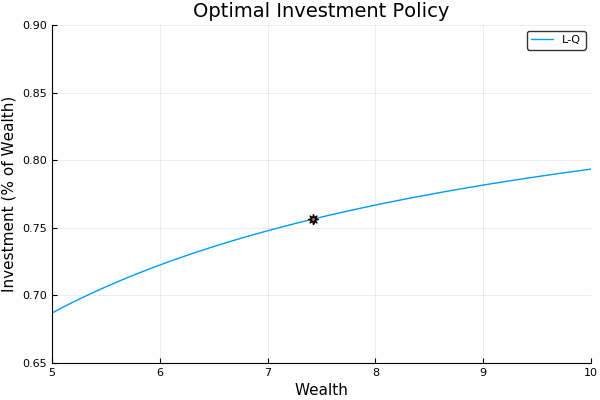

In [16]:
s_min, s_max = 5, 10
ss = linspace(s_min, s_max, 50)
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(ss, X.(ss)./ss, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="L-Q")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")

## Renewable Resource Management

Consider the renewable resource management model from Miranda and Fackler, Section 9.7.2:

* $f(s, x) = \dfrac{(s - x)^{1-\gamma}}{1-\gamma} - \kappa (s - x)$,
* $g(s, x) = \alpha x - 0.5 \beta x^2$.

In [17]:
alpha = 4.0
bet = 1.0
gamm = 0.5
kappa = 0.2
discount = 0.9;

In [18]:
f(s, x) = (s - x)^(1 - gamm) / (1 - gamm) - kappa * (s - x)
f_s(s, x) = (s - x)^(-gamm) - kappa
f_x(s, x) = -f_s(s, x)
f_ss(s, x) = -gamm * (s - x)^(-gamm - 1)
f_sx(s, x) = -f_ss(s, x)
f_xx(s, x) = f_ss(s, x)

g(s, x) = alpha * x - 0.5 * bet * x^2
g_s(s, x) = 0
g_x(s, x) = alpha - bet * x;

In [19]:
x_star = (discount * alpha - 1) / (discount * bet)
s_star = (alpha^2 - 1/discount^2) / (2 * bet)
s_star, x_star

(7.382716049382716, 2.888888888888889)

In [20]:
f_x(s_star, x_star) + discount * f_s(g(s_star, x_star), x_star) * g_x(s_star, x_star)

5.551115123125783e-17

In [21]:
f_star = f(s_star, x_star)
Df_star = [f_s(s_star, x_star), f_x(s_star, x_star)]
DDf_star = [f_ss(s_star, x_star) f_sx(s_star, x_star);
            f_sx(s_star, x_star) f_xx(s_star, x_star)]
g_star = g(s_star, x_star)
Dg_star = [g_s(s_star, x_star), g_x(s_star, x_star)];

In [22]:
lq = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)

QuantEcon.LQ([0.0262431], [-1.5899 -0.253796; -0.253796 0.0262431], [1.0 0.0; 4.17284 0.0], [0.0; 1.11111], [0.0; 0.0], [0.253796 -0.0262431], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [23]:
P, F, d = stationary_values(lq)

([-31.2605 -0.155239; -0.155239 0.00262431], [3.75556 -0.9], 0.0)

In [24]:
V(s) = [1, s]' * P * [1, s] + d

V (generic function with 1 method)

In [25]:
V(s_star)

-33.40964351976545

In [26]:
-f_star / (1 - lq.bet)

-33.409643519765496

In [27]:
X(s) = - (F * [1, s])[1]

X (generic function with 1 method)

In [28]:
X(s_star)

2.888888888888884

In [29]:
x_star

2.888888888888889


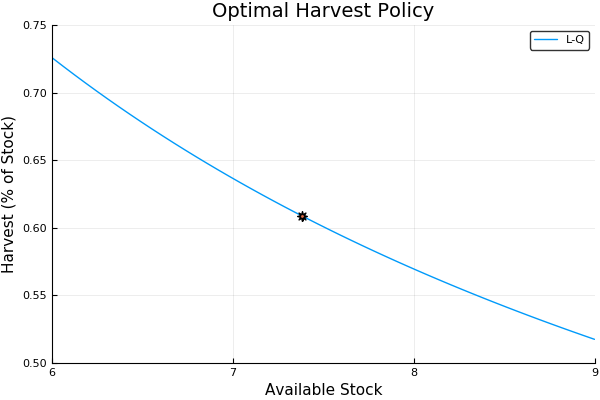

In [30]:
s_min, s_max = 6, 9
ss = linspace(s_min, s_max, 50)
harvest = ss - X.(ss)
h_star = s_star - x_star
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest (% of Stock)"
plot(ss, harvest./ss, xlims=(s_min, s_max), ylims=(0.5, 0.75),
     title=title, xlabel=xlabel, ylabel=ylabel, label="L-Q")
plot!([s_star], [h_star/s_star], m=(7,:star8), label="")


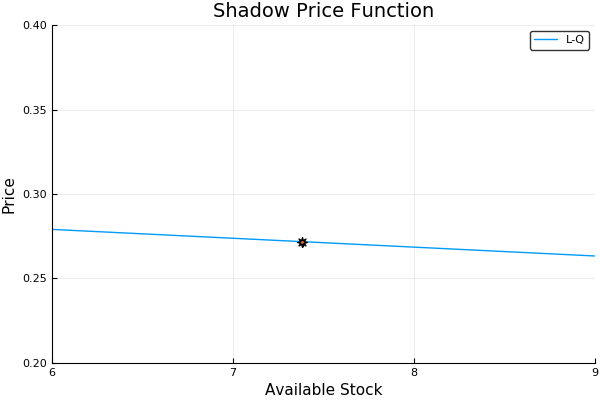

In [31]:
shadow_price(s) = -2 * (P * [1, s])[2]
title = "Shadow Price Function"
ylabel = "Price"
plot(ss, shadow_price.(ss), xlims=(s_min, s_max), ylims=(0.2, 0.4),
     title=title, xlabel=xlabel, ylabel=ylabel, label="L-Q")
plot!([s_star], [shadow_price(s_star)], m=(7,:star8), label="")